<a href="https://colab.research.google.com/github/dantonnoriega/csulb-data-day-2025/blob/solutions/danton_solutions_csulb_data_day_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSULB Data Day 2025
*(Danton's Break Out Session)*


**Motivating Question**
> Which compute instance profile strategy would you recommend for each compute request scenarios (`low`, `normal`, `high`)?

### Learning Goals

* **Exposure to industry-inspired questions** about the cost and usage of compute infrastructure
* **Work with relevant data** (albiet simplified and simulated) data virtually all major companies are analyzing
* **Practice using coding AI Assistants** and understand how to use them effectively
  * AI Assistants are good enough that one can now "vibecode" (code using English)
  * This is *adventagous* for experienced data scientist but a *disadvantage* to new ones
* **Learn about `polars`**, my favorite package for working with data frames!

In [37]:
# GOAL:
# - find the best instance allocation strategy for each request scenario: low, normal, high

# General Set Up
import polars as pl
import plotnine as p9
pl.Config.set_tbl_cols(10)
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_width_chars(200)

polars.config.Config

In [38]:
# prompt: read in a csv as `scenarios_df` with polars from a public repo url: `https://github.com/dantonnoriega/csulb-data-day-2025/blob/main/data/compute_request_scenarios.csv`
# tip: try_parse_dates=True

scenarios_df = pl.read_csv("https://raw.githubusercontent.com/dantonnoriega/csulb-data-day-2025/main/data/compute_request_scenarios.csv", try_parse_dates=True)
print(scenarios_df)

shape: (13_032, 3)
┌─────────────────────┬──────────┬──────────┐
│ datetime            ┆ scenario ┆ requests │
│ ---                 ┆ ---      ┆ ---      │
│ datetime[μs]        ┆ str      ┆ i64      │
╞═════════════════════╪══════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ normal   ┆ 2519     │
│ 2023-01-01 01:00:00 ┆ normal   ┆ 1577     │
│ 2023-01-01 02:00:00 ┆ normal   ┆ 1277     │
│ 2023-01-01 03:00:00 ┆ normal   ┆ 921      │
│ 2023-01-01 04:00:00 ┆ normal   ┆ 781      │
│ 2023-01-01 05:00:00 ┆ normal   ┆ 1171     │
│ 2023-01-01 06:00:00 ┆ normal   ┆ 2779     │
│ 2023-01-01 07:00:00 ┆ normal   ┆ 5168     │
│ 2023-01-01 08:00:00 ┆ normal   ┆ 6861     │
│ 2023-01-01 09:00:00 ┆ normal   ┆ 10120    │
│ …                   ┆ …        ┆ …        │
│ 2023-06-30 14:00:00 ┆ low      ┆ 25160    │
│ 2023-06-30 15:00:00 ┆ low      ┆ 20743    │
│ 2023-06-30 16:00:00 ┆ low      ┆ 16951    │
│ 2023-06-30 17:00:00 ┆ low      ┆ 19409    │
│ 2023-06-30 18:00:00 ┆ low      ┆ 13199    │
│ 2023-06-30 19

In [58]:
# prompt: add a "year-month" column `ym` using column `datetime` to data frame `scenarios_df`

scenarios_df = scenarios_df.with_columns(
    pl.col("datetime").dt.strftime("%Y-%m").alias("ym")
)
print(scenarios_df)


shape: (13_032, 4)
┌─────────────────────┬──────────┬──────────┬─────────┐
│ datetime            ┆ scenario ┆ requests ┆ ym      │
│ ---                 ┆ ---      ┆ ---      ┆ ---     │
│ datetime[μs]        ┆ str      ┆ i64      ┆ str     │
╞═════════════════════╪══════════╪══════════╪═════════╡
│ 2023-01-01 00:00:00 ┆ normal   ┆ 2519     ┆ 2023-01 │
│ 2023-01-01 01:00:00 ┆ normal   ┆ 1577     ┆ 2023-01 │
│ 2023-01-01 02:00:00 ┆ normal   ┆ 1277     ┆ 2023-01 │
│ 2023-01-01 03:00:00 ┆ normal   ┆ 921      ┆ 2023-01 │
│ 2023-01-01 04:00:00 ┆ normal   ┆ 781      ┆ 2023-01 │
│ 2023-01-01 05:00:00 ┆ normal   ┆ 1171     ┆ 2023-01 │
│ 2023-01-01 06:00:00 ┆ normal   ┆ 2779     ┆ 2023-01 │
│ 2023-01-01 07:00:00 ┆ normal   ┆ 5168     ┆ 2023-01 │
│ 2023-01-01 08:00:00 ┆ normal   ┆ 6861     ┆ 2023-01 │
│ 2023-01-01 09:00:00 ┆ normal   ┆ 10120    ┆ 2023-01 │
│ …                   ┆ …        ┆ …        ┆ …       │
│ 2023-06-30 14:00:00 ┆ low      ┆ 25160    ┆ 2023-06 │
│ 2023-06-30 15:00:00 ┆ low  

In [59]:
# prompt: reorder columns in `scenarios_df` as `datetime`, `ym`, `scenario`, `requests`

scenarios_df = scenarios_df.select(['datetime', 'ym', 'scenario', 'requests'])
print(scenarios_df)


shape: (13_032, 4)
┌─────────────────────┬─────────┬──────────┬──────────┐
│ datetime            ┆ ym      ┆ scenario ┆ requests │
│ ---                 ┆ ---     ┆ ---      ┆ ---      │
│ datetime[μs]        ┆ str     ┆ str      ┆ i64      │
╞═════════════════════╪═════════╪══════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ 2023-01 ┆ normal   ┆ 2519     │
│ 2023-01-01 01:00:00 ┆ 2023-01 ┆ normal   ┆ 1577     │
│ 2023-01-01 02:00:00 ┆ 2023-01 ┆ normal   ┆ 1277     │
│ 2023-01-01 03:00:00 ┆ 2023-01 ┆ normal   ┆ 921      │
│ 2023-01-01 04:00:00 ┆ 2023-01 ┆ normal   ┆ 781      │
│ 2023-01-01 05:00:00 ┆ 2023-01 ┆ normal   ┆ 1171     │
│ 2023-01-01 06:00:00 ┆ 2023-01 ┆ normal   ┆ 2779     │
│ 2023-01-01 07:00:00 ┆ 2023-01 ┆ normal   ┆ 5168     │
│ 2023-01-01 08:00:00 ┆ 2023-01 ┆ normal   ┆ 6861     │
│ 2023-01-01 09:00:00 ┆ 2023-01 ┆ normal   ┆ 10120    │
│ …                   ┆ …       ┆ …        ┆ …        │
│ 2023-06-30 14:00:00 ┆ 2023-06 ┆ low      ┆ 25160    │
│ 2023-06-30 15:00:00 ┆ 2023-

In [57]:
# prompt: sum `requests` by `ym` and `scenario`, sort, then save as object `scenarios_by_ym_df`

scenarios_by_ym_df = (
    scenarios_df
    .group_by(["ym", "scenario"])
    .agg(pl.col("requests").sum())
    .sort(["ym", "scenario"])
)


AttributeError: 'DataFrame' object has no attribute 'groupby'

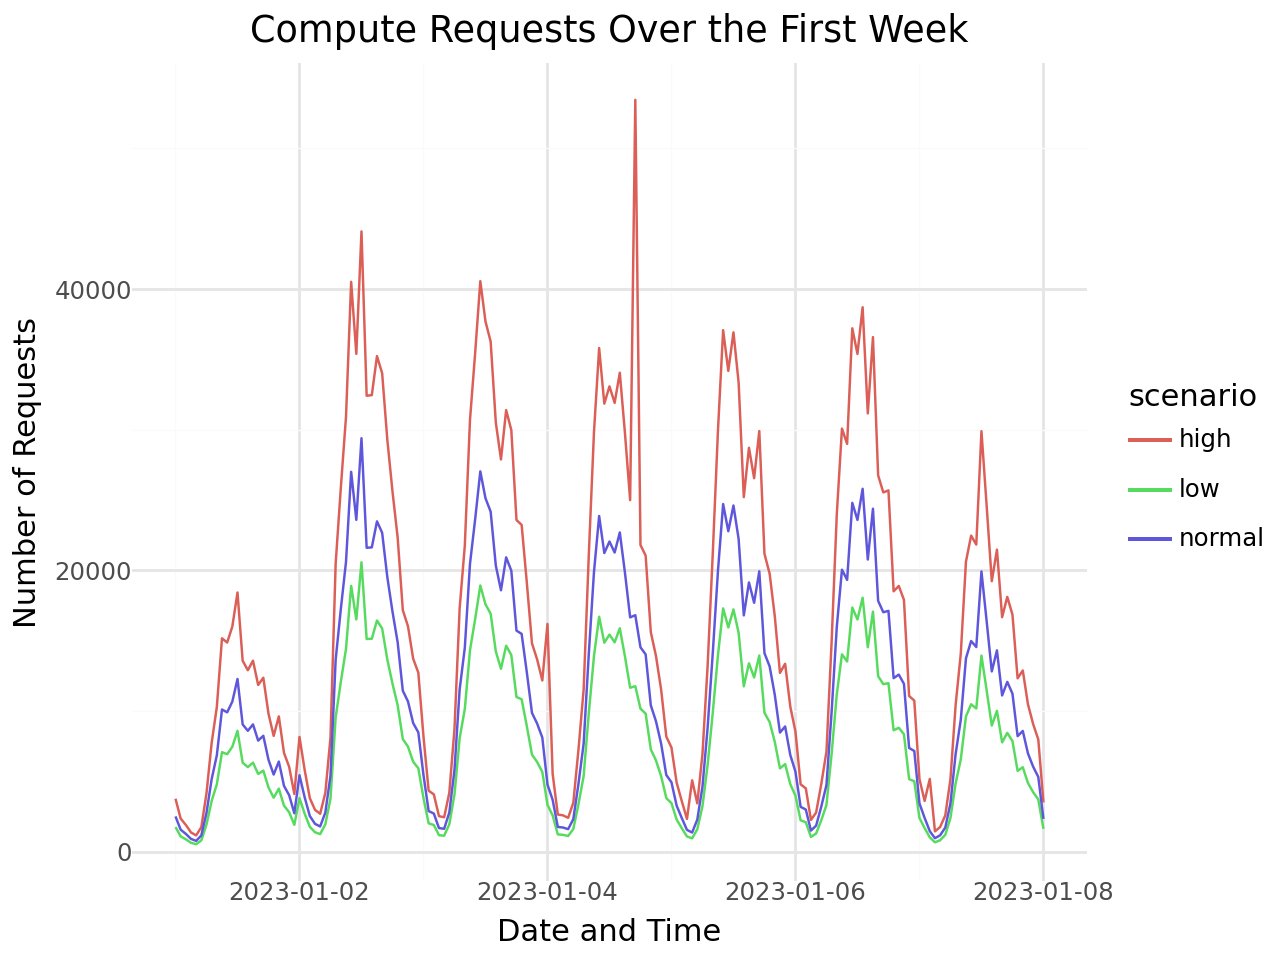

In [41]:
# prompt: filter data frame `scenarios_df` to the first week of data then create a line plot using plotnine grouped by `scenario` with x = `datetime` and y = `requests`
# tip: p9.theme_minimal()

# Filter data to the first week
first_week_df = scenarios_df.filter(
    pl.col("datetime") <= scenarios_df["datetime"].min() + pl.duration(days=7)
)

# Create the line plot using plotnine
(
    p9.ggplot(first_week_df, p9.aes(x="datetime", y="requests", color="scenario"))
    + p9.geom_line()
    + p9.labs(
        title="Compute Requests Over the First Week",
        x="Date and Time",
        y="Number of Requests",
    )
    + p9.theme_minimal()
)


## Determine Allocations

In [15]:
# instruction:
## create a data frame with columns: strategy, hourly_capacity, hourly_cost
## using the dictionary objects below

# Instance Strategies ----------------------

# Strategy 1: Cost Efficiency - Many smaller instances
cost_efficiency_allocation = {
    "micro": 25,
    "small": 20,
    "medium": 17,
    "large": 6,
    "xlarge": 1
}

# Strategy 2: Performance - Fewer, more powerful instances
performance_allocation = {
    "micro": 0,
    "small": 0,
    "medium": 0,
    "large": 6,
    "xlarge": 15
}

# Strategy 3: Balanced - Mix of instance types
balanced_allocation = {
    "micro": 10,
    "small": 15,
    "medium": 8,
    "large": 5,
    "xlarge": 7
}

In [44]:
# instruction:
## - read the csv file at https://github.com/dantonnoriega/csulb-data-day-2025/blob/main/data/compute_instance_profiles.csv
## - to object named `instances_df` and print it

instances_df = pl.read_csv("https://raw.githubusercontent.com/dantonnoriega/csulb-data-day-2025/main/data/compute_instance_profiles.csv")
print(instances_df)

shape: (5, 3)
┌───────────────┬───────────────────┬───────────────┐
│ instance_type ┆ requests_per_hour ┆ cost_per_hour │
│ ---           ┆ ---               ┆ ---           │
│ str           ┆ i64               ┆ f64           │
╞═══════════════╪═══════════════════╪═══════════════╡
│ micro         ┆ 100               ┆ 0.012         │
│ small         ┆ 250               ┆ 0.024         │
│ medium        ┆ 600               ┆ 0.048         │
│ large         ┆ 1500              ┆ 0.096         │
│ xlarge        ┆ 4000              ┆ 0.192         │
└───────────────┴───────────────────┴───────────────┘
